# AlphaZero Version 1

This model is based on the model used in [Chess Alpha Zero](https://github.com/Zeta36/chess-alpha-zero). In contrast to Chess Alpha Zero, this model does not have a Dense Layer for the policy output. Also it does not yet have a value output.

The architecture is modified to be fully convolutional to allow for arbitraryly sized board inputs.

This model uses a custom Keras layer `LineFilterLayer` for the policy output. The `LineFilterLayer` uses a Tensorflow's `boolean_mask` method to filter out all but the lines in the output image. As a result, the policy output is a vector of all lines in the Dots and Boxes game. The training data is converted accordingly.

The target images in the StageOne dataset always show exactly one line, which is the action of the Hard AI in KSquares. 

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.python import debug as tf_debug

from keras.callbacks import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
import keras.backend as K
from keras.regularizers import l2
from keras.engine.topology import Layer

from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
import random

modelPath = 'model/alphaZeroV1.h5'

In [2]:
print(K.image_data_format()) 
# expected output: channels_last

channels_last


In [3]:
model = load_model(modelPath)

In [3]:
def dotsAndBoxesToCategorical(inputData):
    inp = np.copy(inputData)
    inp[inp == 255] = 1 # Line - comes first so that target data only has two categories
    inp[inp == 65] = 2 # Box A
    inp[inp == 150] = 3 # Box B
    inp[inp == 215] = 4 # Dot
    cat = to_categorical(inp)
    newShape = inp.shape + (cat.shape[-1],)
    return cat.reshape(newShape)

In [4]:
rawDataset = np.load('stageOne5x4.npz')
x_train = rawDataset['x_train']
y_train = rawDataset['y_train']
x_train_cat = dotsAndBoxesToCategorical(x_train)
y_train_cat = dotsAndBoxesToCategorical(y_train)

np.set_printoptions(precision=2)

print("original data:")
print(x_train[0])
print(y_train[0])
print(x_train.shape)
print(y_train.shape)

print("\nnormalized data:")
print(np.transpose(x_train_cat[0]))
print(np.transpose(y_train_cat[0]))
print(x_train_cat.shape)
print(y_train_cat.shape)

original data:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215   0 215   0 215   0]
 [  0   0   0   0   0 255   0   0   0   0   0 255   0]
 [  0 215   0 215   0 215   0 215   0 215   0 215   0]
 [  0   0   0 255   0   0   0   0   0 255   0   0   0]
 [  0 215   0 215   0 215 255 215 255 215   0 215   0]
 [  0   0   0   0   0   0   0 255   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215   0 215 255 215   0]
 [  0 255   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215 255 215 255 215   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0

In [5]:
def imgSizeToBoxes(x):
    return (x-3)/2

def lineFilterMatrixNP(imgWidth,imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=np.bool)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = 1
    return mat

lineFilterMatrixNP(13,11)

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True,

In [6]:
y_train_lines = y_train[:,lineFilterMatrixNP(y_train.shape[-1], y_train.shape[-2])]
print(y_train_lines.shape)
print(y_train_lines[0])

(1000000, 49)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]


## LineFilterLayer

This layer takes n_samples of Dots and Boxes images and returns
only the line pixels in a flattened list
```
input: (n_samples, img_height, img_width)
output: (n_samples, lines_cnt)

box_width = (img_width-3)/2
box_height = (img_height-3)/2
lines_cnt = 2 * box_width * box_height + box_width + box_height
```


In [7]:
'''
This layer takes n_samples of Dots and Boxes images and returns
only the line pixels in a flattened list
input: (n_samples, img_height, img_width)
output: (n_samples, 2*((w-3)/2)*((h-3)/2) + ((w-3)/2) + ((h-3)/2)) 
where w is img_width and h is img_height
'''
class LineFilterLayer(Layer):
    def __init__(self, imgWidth, imgHeight, **kwargs):
        self.filterMatrix = self.lineFilterMatrix(imgWidth, imgHeight)
        print(self.filterMatrix)
        w = imgWidth
        h = imgHeight
        self.output_dim = 2*((w-3)/2)*((h-3)/2) + ((w-3)/2) + ((h-3)/2) 
        super(LineFilterLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        shape = list(input_shape)
        print(input_shape)
        assert len(shape) == 4
        assert shape[3] == 1
        self.compute_output_shape(input_shape)
        super(LineFilterLayer, self).build(input_shape)

    def call(self, x):
        assert self.filterMatrix is not None
        assert self.output_dim is not None
        assert self.output_dim > 0
        lines2D = tf.boolean_mask(x, self.filterMatrix, name='lineFilter', axis=1)
        shape = K.shape(lines2D)
        #print(shape)
        #print(shape[0])
        return tf.reshape(lines2D, (shape[0], self.output_dim))
        return lines2D

    def compute_output_shape(self, input_shape):
        w = input_shape[-2]
        h = input_shape[-3]
        if w is None or h is None:
            return (input_shape[0], None)
        self.filterMatrix = self.lineFilterMatrix(w,h)
        wbox = self.imgSizeToBoxes(w)
        hbox = self.imgSizeToBoxes(h)
        self.output_dim = 2 * wbox * hbox + wbox + hbox
        return (input_shape[0], self.output_dim)
    
    
    def imgSizeToBoxes(self, x):
        if x is None:
            return None
        return (x-3)/2

    def lineFilterMatrix(self, imgWidth,imgHeight):
        boxWidth = imgSizeToBoxes(imgWidth)
        boxHeight = imgSizeToBoxes(imgHeight)
        linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
        mat = np.zeros((imgHeight, imgWidth), dtype=np.bool)
        for idx in range(linesCnt):
            y1 = idx / ((2*boxWidth) + 1)
            if idx % ((2*boxWidth) + 1) < boxWidth:
                # horizontal line
                x1 = idx % ((2*boxWidth) + 1)
                x2 = x1 + 1
                y2 = y1
            else:
                # vertical line
                x1 = idx % ((2*boxWidth) + 1) - boxWidth
                x2 = x1
                y2 = y1 + 1
            px = x2 * 2 + y2 - y1
            py = y2 * 2 + x2 - x1
            mat[py,px] = 1
        return tf.convert_to_tensor(mat)

In [9]:
kernelSize = (5,5)
filterCnt = 64
l2reg = 1e-4
resBlockCnt = 4

def build_residual_block(x, index):
        in_x = x
        res_name = "res"+str(index)
        x = Conv2D(filters=filterCnt, kernel_size=kernelSize, padding="same",
                   data_format="channels_last", kernel_regularizer=l2(l2reg), 
                   name=res_name+"_conv1_"+str(filterCnt))(x)
        x = BatchNormalization(name=res_name+"_batchnorm1")(x)
        x = Activation("relu",name=res_name+"_relu1")(x)
        x = Conv2D(filters=filterCnt, kernel_size=kernelSize, padding="same",
                   data_format="channels_last", kernel_regularizer=l2(l2reg), 
                   name=res_name+"_conv2-"+str(filterCnt))(x)
        x = BatchNormalization(name="res"+str(index)+"_batchnorm2")(x)
        x = Add(name=res_name+"_add")([in_x, x])
        x = Activation("relu", name=res_name+"_relu2")(x)
        return x


img_input = Input(shape=(None,None,5,))
x = Conv2D(filterCnt, kernelSize, padding='same', kernel_regularizer=l2(l2reg), name="input_conv")(img_input)
x = Activation("relu", name="input_relu")(x)
x = BatchNormalization()(x)

for i in range(resBlockCnt):
    x = build_residual_block(x, i+1)

res_out = x

x = Conv2D(1, kernelSize, padding='same', kernel_regularizer=l2(l2reg), name="output_conv")(x)
x = LineFilterLayer(y_train.shape[-1], y_train.shape[-2])(x)
x = Activation("softmax", name="output_softmax")(x)
    
model = Model(inputs=img_input, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy')

model.summary()

Tensor("Const_1:0", shape=(11, 13), dtype=bool)
(None, None, None, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 5 0                                            
__________________________________________________________________________________________________
input_conv (Conv2D)             (None, None, None, 6 8064        input_2[0][0]                    
__________________________________________________________________________________________________
input_relu (Activation)         (None, None, None, 6 0           input_conv[0][0]                 
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, None, None, 6 256         input_relu[0][0]                 
_______________________________________

In [37]:
#sess = K.get_session()
#sess = tf_debug.LocalCLIDebugWrapperSession(sess)
#K.set_session(sess)

# Training
callbacks = []

checkpoint = ModelCheckpoint(filepath='model/AlphaZeroV1-checkpoint.h5', save_weights_only=False)
callbacks.append(checkpoint)

progbar = ProgbarLogger()
callbacks.append(progbar)

tensorboard = TensorBoard(log_dir='model/log2', write_grads=True, write_graph=True, write_images=True, histogram_freq=1)
callbacks.append(tensorboard)

model.fit(x_train_cat, y_train_lines, epochs=5, batch_size=64, callbacks=callbacks, validation_split=0.001)

model.save(modelPath)

Train on 999000 samples, validate on 1000 samples
Epoch 1/5
Epoch 1/5
179904/999000 [====>.........................] - ETA: 29:46 - loss: 664.4174

KeyboardInterrupt: 

In [30]:
def linesToDotsAndBoxesImage(lines, imgWidth, imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=lines.dtype)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = lines[idx]
    return mat

example: 829790
[[3 0 3 0 0 3 3 3 3 3 2 0 3 3 3 3 3 3 3 3 3 3 3 3 2 0 3 3 0 3 0 0 3 3 0 0
  0 0 3 0 0 0 3 3 0 0 0 3 0]]
1.0
input (11, 13): 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215   0 215 255 215   0 215 255 215 255 215   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215 255 215   0 215   0 215   0 215   0 215   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215   0 215   0 215   0]
 [  0   0   0 255   0   0   0 255   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215 255 215 255 215   0]
 [  0   0   0   0   0 255   0   0   0   0   0   0   0]
 [  0 215 255 215 255 215 255 215   0 215   0 215   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]
prediction: 
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 3 0 0 0 0 0 0]
 [0 3 0 3 0 3 0 3 0 3 0 2 0]
 [0 0 0 0 3 0 3 0 3 0 3 0 0]
 [0 3 0 3 0 3 0 3 0 3 0 3 0]
 [0 0 3 0 3 0 2 0 0 0 3 0 0]
 [0 3 0 0 0 3 0 0 0 0 0 3 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 

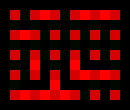

In [36]:
example = random.randrange(x_train.shape[0])
print("example: "+str(example))

input_data = x_train[example:example+1]
input_data_cat = x_train_cat[example:example+1]

prediction_lines = model.predict(input_data_cat)
prediction_lines_print = prediction_lines * 100
print(prediction_lines_print.astype(np.uint8))
print(np.sum(prediction_lines))
prediction = linesToDotsAndBoxesImage(prediction_lines[0], x_train.shape[2], x_train.shape[1])

# print input data
input_data_print = x_train[example,:,:] 
input_data_print = input_data_print.astype(np.uint8)
print("input "+str(input_data_print.shape)+": ")
print(input_data_print)

# generate greyscale image data from input data
target_imgdata = x_train[example,:,:] 
target_imgdata = target_imgdata.astype(np.uint8)

# print prediction
prediction_data_print = prediction * 100 
prediction_data_print = prediction_data_print.astype(np.uint8)
print("prediction: ")
print(prediction_data_print)

# generate greyscale image data from prediction data
prediction_imgdata = prediction * 255
prediction_imgdata = prediction_imgdata.astype(np.uint8)

# merge image data in color channels
tmp = np.zeros((prediction.shape[0], prediction.shape[1]), dtype=np.uint8)
merged_imgdata = np.stack([target_imgdata, prediction_imgdata, tmp], axis=2)

#create image
img = Image.fromarray(merged_imgdata, 'RGB')
img = img.resize(size=(img.size[0]*10, img.size[1]*10))

img